In [4]:
import numpy as np
import matplotlib.pyplot as plt
# import eli5
import torch # For building the networks
import torchtuples as tt # Some useful functions
import seaborn as sns
import warnings
import pandas as pd
import torch.nn as nn
import torch.nn.functional as F


# from eli5.sklearn import PermutationImportance
# from eli5.permutation_importance import get_score_importances
# For preprocessing
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn_pandas import DataFrameMapper

from pycox.models import LogisticHazard
# from pycox.models import PMF
from pycox.models import DeepHitSingle
from pycox.evaluation import EvalSurv
from pycox.evaluation.concordance import concordance_td
from pycox.evaluation import ipcw, admin
from pycox import utils

from statsmodels.stats.outliers_influence import variance_inflation_factor
from statsmodels.tools.tools import add_constant
from sklearn.model_selection import train_test_split
from torch.utils.data import Dataset
from torchtuples.tupletree import tuplefy

In [5]:
# np.random.seed(42)
# _ = torch.manual_seed(42)

## Dataset

We load the METABRIC data set as a pandas DataFrame and split the data in in train, test and validation.

The `duration` column gives the observed times and the `event` column contains indicators of whether the observation is an event (1) or a censored observation (0).

# dataset 

In [6]:
df_all = pd.read_csv('Metabric_selected.csv')
df_all.drop('Unnamed: 0', inplace=True, axis=1)
df_train, df_temp = train_test_split(df_all, train_size=0.65)
df_val, df_test = train_test_split(df_temp, test_size=0.5)


In [7]:



train_size = 0.65

df_train, df_temp = train_test_split(df_all, train_size=0.65, stratify =df_all['chemotherapy'])
df_val, df_test = train_test_split(df_temp, test_size=0.5, stratify =df_temp['chemotherapy'])

print(f"Training set size: {len(df_train)}")
print(f"Validation set size: {len(df_val)}")
print(f"Test set size: {len(df_test)}")


df_train.to_csv('Metabric_combined_train.csv', index=False)
df_val.to_csv('Metabric_combined_val.csv', index=False)
df_test.to_csv('Metabric_combined_test.csv', index=False)



Training set size: 1237
Validation set size: 333
Test set size: 334


In [8]:
df_all['chemotherapy']

0       0
1       0
2       1
3       1
4       1
       ..
1899    0
1900    0
1901    0
1902    0
1903    0
Name: chemotherapy, Length: 1904, dtype: int64

In [9]:


categories = pd.Index(['cellularity',
 'chemotherapy',
 'er_status',
 'neoplasm_histologic_grade',
 'her2_status',
 'hormone_therapy',
 'pr_status',
 'radio_therapy',
 'pam50_+_claudin-low_subtype_Basal',
 'pam50_+_claudin-low_subtype_Her2',
 'pam50_+_claudin-low_subtype_LumA',
 'pam50_+_claudin-low_subtype_LumB',
 'pam50_+_claudin-low_subtype_Normal',
 'pam50_+_claudin-low_subtype_claudin-low'])

In [10]:
df_train

,abcb1,acvr1b,age_at_diagnosis,bmp10,bmp3,cdkn2a,chemotherapy,col22a1,ctcf,cul1,...,src,stat5a,stmn2,tubb4a,tubb4b,tumor_size,ugt2b17,wwox,event,overall_survival_months
834,-0.0318,0.5338,70.75,-0.6817,-0.2334,-0.5526,0,-0.3808,0.1874,-0.1449,...,-0.3034,0.6763,0.0296,-1.0714,-0.0943,29.0,0.6873,0.5943,1,168.266667
624,-0.3657,-0.1512,49.92,0.5150,0.0101,-0.3750,0,0.2385,1.3330,0.3343,...,-0.6000,0.7708,1.1552,1.3581,0.0044,22.0,4.3874,-0.2349,0,261.200000
1254,1.3943,-0.0196,52.77,-0.0808,-0.0407,-0.1290,0,-0.0948,-0.0670,-1.1824,...,0.1726,-1.5123,-0.4963,-0.4274,0.1872,15.0,0.1868,0.8168,1,71.066667
93,-0.8082,-1.6391,74.63,-0.9511,-0.9446,0.1189,0,-0.2262,1.1443,-0.6347,...,0.2713,-0.9220,-1.3252,4.4144,0.9291,21.0,-0.2792,0.9000,1,104.466667
894,-0.5863,1.1454,59.13,-0.9109,1.5662,-0.5136,0,0.5207,0.8442,-1.2988,...,1.9749,-1.3486,-0.2728,-0.8063,1.1198,23.0,0.5691,1.0062,1,90.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
634,-0.3054,-2.3629,55.30,-0.3307,2.0316,2.7159,1,2.1839,-0.9568,0.0855,...,1.3977,-0.6928,-0.3957,0.7648,0.3218,43.0,-0.0615,-0.4321,1,32.033333
904,-0.2621,0.0111,54.27,-0.1399,-0.2354,-0.7049,0,-0.8204,0.0256,-0.3901,...,0.0749,0.9070,-0.1170,-0.2154,0.0544,18.0,0.4183,-0.8673,0,260.200000
272,-0.7829,0.9824,54.22,-0.4219,0.4623,-0.4364,0,0.0453,0.4381,-0.6732,...,-0.2836,-0.7600,-0.3748,2.1965,-0.7681,40.0,2.6335,1.3165,1,6.266667
168,0.5767,0.2726,47.64,-0.0046,-0.8193,-0.7731,0,-0.7250,2.0851,-2.4308,...,-0.4800,0.2925,-0.2454,-0.0759,1.7283,21.0,1.1487,-0.6670,1,172.900000


In [11]:



final_columns = df_train.columns.to_list()
final_columns.remove('event')
final_columns.remove('overall_survival_months')
cat_cols = list(set(final_columns) & set(categories.to_list()))
num_cols = list(set(final_columns) - set(cat_cols))
# final_columns

In [12]:
def preprocess_dataset(data, num_cols, cat_cols):
    standardize = [([col], StandardScaler()) for col in num_cols]
    x_mapper = DataFrameMapper(standardize)
    input_x_num = x_mapper.fit_transform(data).astype('float32')
    
    input_ids = np.zeros([input_x_num.shape[0], len(cat_cols)])
    vocab_size = 0
    for i,feat in enumerate(cat_cols):
        input_ids[:,i] = LabelEncoder().fit_transform(data[feat]).astype('float32') + vocab_size
        vocab_size += data[feat].max() + 1
    return np.concatenate((input_ids, input_x_num), axis=1), vocab_size

In [13]:

cat_cols = list(set(final_columns) & set(categories.to_list()))
num_cols = list(set(final_columns) - set(cat_cols))
x_train, vocab_size = preprocess_dataset(df_train, num_cols, cat_cols)
x_val, _ = preprocess_dataset(df_val, num_cols, cat_cols)
x_test, _ = preprocess_dataset(df_test, num_cols, cat_cols)

## Model

# CoxPH + Model Multiheaf and Residual 

# Pavlentii

In [14]:
import torch
import torch.nn as nn
import torch.nn.functional as F


def tuplefy(*args):
    return tuple([arg if isinstance(arg, (tuple, list)) else (arg,) for arg in args])

class BertEmbeddings(nn.Module):
    def __init__(self, vocab_size, hidden_size, num_numerical_feature, max_position_embeddings):
        super().__init__()
        self.word_embeddings = nn.Embedding(vocab_size, hidden_size)
        self.position_embeddings = nn.Embedding(max_position_embeddings, hidden_size)
        self.num_embeddings = nn.Parameter(torch.randn(1, num_numerical_feature, hidden_size), requires_grad=True)
        self.num_numerical_feature = num_numerical_feature

    def forward(self, input):
        input_ids = input[:, :-self.num_numerical_feature].to(torch.int)
        inputs_embeds = self.word_embeddings(input_ids)

        position_ids = torch.arange(inputs_embeds.size(1), dtype=torch.long, device=input.device)
        position_ids = position_ids.unsqueeze(0).expand_as(input_ids)
        position_embeds = self.position_embeddings(position_ids)

        input_x_num = input[:, -self.num_numerical_feature:]
        num_embeddings = torch.unsqueeze(input_x_num, 2) * self.num_embeddings

        embeddings = torch.cat([inputs_embeds + position_embeds, num_embeddings], axis=1)
        embeddings = embeddings.to(torch.float)
        return embeddings


class MultiHeadSelfAttentionLayer(nn.Module):
    def __init__(self, hidden_size, num_heads):
        super(MultiHeadSelfAttentionLayer, self).__init__()
        self.num_heads = num_heads
        self.hidden_size = hidden_size
        self.head_dim = hidden_size // num_heads

        assert self.head_dim * num_heads == hidden_size, "hidden_size must be divisible by num_heads"

        self.key = nn.Linear(hidden_size, hidden_size)
        self.query = nn.Linear(hidden_size, hidden_size)
        self.value = nn.Linear(hidden_size, hidden_size)
        self.out = nn.Linear(hidden_size, hidden_size)

    def forward(self, x, mask=None, extract_heatmap=False):
        batch_size = x.size(0)
        seq_length = x.size(1)

        keys = self.key(x).view(batch_size, seq_length, self.num_heads, self.head_dim).transpose(1, 2)
        queries = self.query(x).view(batch_size, seq_length, self.num_heads, self.head_dim).transpose(1, 2)
        values = self.value(x).view(batch_size, seq_length, self.num_heads, self.head_dim).transpose(1, 2)

        scores = torch.matmul(queries, keys.transpose(-2, -1)) / torch.sqrt(torch.tensor(self.head_dim, dtype=torch.float32))

        if mask is not None:
            scores = scores.masked_fill(mask == 0, -1e9)

        attention_weights = F.softmax(scores, dim=-1)

        if extract_heatmap:
            return attention_weights.detach().cpu().numpy()  
        
        output = torch.matmul(attention_weights, values)
        output = output.transpose(1, 2).contiguous().view(batch_size, seq_length, self.hidden_size)

        output = self.out(output)
        return output, attention_weights


class ResidualMLPBlock(nn.Module):
    def __init__(self, in_features, out_features, bias=True, batch_norm=False, dropout=0., activation=nn.ReLU,
                 w_init_=lambda w: nn.init.kaiming_normal_(w, nonlinearity='relu'), batch_features=0):
        super().__init__()
        self.linear = nn.Linear(in_features, out_features, bias)
        if w_init_:
            w_init_(self.linear.weight.data)
        self.activation = activation()
        self.batch_norm = nn.BatchNorm1d(batch_features) if batch_norm else None
        self.dropout = nn.Dropout(dropout) if dropout else None
        self.residual = nn.Linear(in_features, out_features) if in_features != out_features else nn.Identity()

    def forward(self, input):
        residual = self.residual(input)
        input = self.activation(self.linear(input))
        if self.batch_norm:
            input = self.batch_norm(input)
        if self.dropout:
            input = self.dropout(input)
        return input + residual

class MLPBlock(nn.Module):
    def __init__(self, in_features, out_features, bias=True, batch_norm=False, dropout=0., activation=nn.ReLU,
                 w_init_=lambda w: nn.init.kaiming_normal_(w, nonlinearity='relu'), batch_features=0):
        super().__init__()
        self.linear = nn.Linear(in_features, out_features, bias)
        if w_init_:
            w_init_(self.linear.weight.data)
        self.activation = activation()
        self.batch_norm = nn.BatchNorm1d(batch_features) if batch_norm else None
        self.dropout = nn.Dropout(dropout) if dropout else None

    def forward(self, input):
        input = self.activation(self.linear(input))
        if self.batch_norm:
            input = self.batch_norm(input)
        if self.dropout:
            input = self.dropout(input)
        return input

class CLF(nn.Module):
    def __init__(self, in_features, out_features, num_features, bias=True, dropout = 0, activation=nn.ReLU,
                 w_init_=lambda w: nn.init.kaiming_normal_(w, nonlinearity='relu')):
        super().__init__()
        self.mlp = MLPBlock(in_features * num_features, in_features, True, True, 0.2, activation, w_init_, in_features)
        self.linear = nn.Linear(in_features, out_features, bias)
        if w_init_:
            w_init_(self.linear.weight.data)

    def forward(self, input):
        input = input.flatten(1)
        input = self.mlp(input)
        input = self.linear(input)
        return input

class MLP__8_with_attention(nn.Module):
    def __init__(self, in_features, num_nodes, out_features, vocab_size, num_numerical_feature,num_features, batch_norm=False, dropout=None, activation=nn.ReLU,
                 output_activation=None, output_bias=True, 
                 w_init_=lambda w: nn.init.kaiming_normal_(w, nonlinearity='relu'), embed_dim=16, max_position_embeddings=512, num_heads=16):
        super().__init__()
        num_nodes_len = tuplefy(num_nodes) 
        dropout = [dropout for _ in range(len(num_nodes_len)-1)]
        net = []
        net.append(BertEmbeddings(vocab_size, embed_dim, num_numerical_feature, max_position_embeddings))
        net.append(MultiHeadSelfAttentionLayer(embed_dim, num_heads))
        net.append(nn.LayerNorm(embed_dim))
       
        net.append(ResidualMLPBlock(embed_dim, num_nodes[0], True, batch_norm, dropout, activation, w_init_, num_features))
        net.append(ResidualMLPBlock(num_nodes[0], num_nodes[1], True, batch_norm, dropout, activation, w_init_ , num_features))
        net.append(ResidualMLPBlock(num_nodes[1], num_nodes[1], True, batch_norm, dropout, activation, w_init_ , num_features))
        
        net.append(ResidualMLPBlock(num_nodes[1], num_nodes[1], True, batch_norm, dropout, activation, w_init_, num_features))
        net.append(ResidualMLPBlock(num_nodes[1], num_nodes[1], True, batch_norm, dropout, activation, w_init_, num_features))
        net.append(ResidualMLPBlock(num_nodes[1], num_nodes[1], True, batch_norm, dropout, activation, w_init_, num_features))
        net.append(ResidualMLPBlock(num_nodes[1], num_nodes[1], True, batch_norm, dropout, activation, w_init_, num_features))
        net.append(ResidualMLPBlock(num_nodes[1], num_nodes[1], True, batch_norm, dropout, activation, w_init_, num_features))
        net.append(CLF(num_nodes[-1], out_features, num_features, output_bias, dropout))  
        if output_activation:
            net.append(output_activation)
        self.net = nn.Sequential(*net)

    def forward(self, input):
        embeddings = self.net[0](input)
        attention_output, _ = self.net[1](embeddings)
        attention_output = self.net[2](attention_output)
        output = self.net[3:](attention_output)
        return output


class MLP__6_with_attention(nn.Module):
    def __init__(self, in_features, num_nodes, out_features, vocab_size, num_numerical_feature,num_features, batch_norm=False, dropout=None, activation=nn.ReLU,
                 output_activation=None, output_bias=True, 
                 w_init_=lambda w: nn.init.kaiming_normal_(w, nonlinearity='relu'), embed_dim=16, max_position_embeddings=512, num_heads=16):
        super().__init__()
        num_nodes_len = tuplefy(num_nodes) 
        dropout = [dropout for _ in range(len(num_nodes_len)-1)]
        net = []
        net.append(BertEmbeddings(vocab_size, embed_dim, num_numerical_feature, max_position_embeddings))
        net.append(MultiHeadSelfAttentionLayer(embed_dim, num_heads))
        net.append(nn.LayerNorm(embed_dim))
       
        net.append(ResidualMLPBlock(embed_dim, num_nodes[0], True, batch_norm, dropout, activation, w_init_, num_features))
        net.append(ResidualMLPBlock(num_nodes[0], num_nodes[1], True, batch_norm, dropout, activation, w_init_ , num_features))
        net.append(ResidualMLPBlock(num_nodes[1], num_nodes[1], True, batch_norm, dropout, activation, w_init_ , num_features))
        
        net.append(ResidualMLPBlock(num_nodes[1], num_nodes[1], True, batch_norm, dropout, activation, w_init_, num_features))
        net.append(ResidualMLPBlock(num_nodes[1], num_nodes[1], True, batch_norm, dropout, activation, w_init_, num_features))
        net.append(ResidualMLPBlock(num_nodes[1], num_nodes[1], True, batch_norm, dropout, activation, w_init_, num_features))

        net.append(CLF(num_nodes[-1], out_features, num_features, output_bias, dropout))  
        if output_activation:
            net.append(output_activation)
        self.net = nn.Sequential(*net)

    def forward(self, input):
        embeddings = self.net[0](input)
        attention_output, _ = self.net[1](embeddings)
        attention_output = self.net[2](attention_output)
        output = self.net[3:](attention_output)
        return output
    
class MLP__4_with_attention(nn.Module):
    def __init__(self, in_features, num_nodes, out_features, vocab_size, num_numerical_feature,num_features, batch_norm=False, dropout=None, activation=nn.ReLU,
                 output_activation=None, output_bias=True, 
                 w_init_=lambda w: nn.init.kaiming_normal_(w, nonlinearity='relu'), embed_dim=16, max_position_embeddings=512, num_heads=16):
        super().__init__()
        num_nodes_len = tuplefy(num_nodes) 
        dropout = [dropout for _ in range(len(num_nodes_len)-1)]
        net = []
        net.append(BertEmbeddings(vocab_size, embed_dim, num_numerical_feature, max_position_embeddings))
        net.append(MultiHeadSelfAttentionLayer(embed_dim, num_heads))
        net.append(nn.LayerNorm(embed_dim))
       
        net.append(ResidualMLPBlock(embed_dim, num_nodes[0], True, batch_norm, dropout, activation, w_init_, num_features))
        net.append(ResidualMLPBlock(num_nodes[0], num_nodes[1], True, batch_norm, dropout, activation, w_init_ , num_features))
        net.append(ResidualMLPBlock(num_nodes[1], num_nodes[1], True, batch_norm, dropout, activation, w_init_ , num_features))
        
        net.append(ResidualMLPBlock(num_nodes[1], num_nodes[1], True, batch_norm, dropout, activation, w_init_, num_features))

        net.append(CLF(num_nodes[-1], out_features, num_features, output_bias, dropout))  
        if output_activation:
            net.append(output_activation)
        self.net = nn.Sequential(*net)

    def forward(self, input):
        embeddings = self.net[0](input)
        attention_output, _ = self.net[1](embeddings)
        attention_output = self.net[2](attention_output)
        output = self.net[3:](attention_output)
        return output

class MLP__2_with_attention(nn.Module):
    def __init__(self, in_features, num_nodes, out_features, vocab_size, num_numerical_feature,num_features, batch_norm=False, dropout=None, activation=nn.ReLU,
                 output_activation=None, output_bias=True, 
                 w_init_=lambda w: nn.init.kaiming_normal_(w, nonlinearity='relu'), embed_dim=16, max_position_embeddings=512, num_heads=16):
        super().__init__()
        num_nodes_len = tuplefy(num_nodes) 
        dropout = [dropout for _ in range(len(num_nodes_len)-1)]
        net = []
        net.append(BertEmbeddings(vocab_size, embed_dim, num_numerical_feature, max_position_embeddings))
        net.append(MultiHeadSelfAttentionLayer(embed_dim, num_heads))
        net.append(nn.LayerNorm(embed_dim))
       
        net.append(ResidualMLPBlock(embed_dim, num_nodes[0], True, batch_norm, dropout, activation, w_init_, num_features))
        net.append(ResidualMLPBlock(num_nodes[0], num_nodes[1], True, batch_norm, dropout, activation, w_init_ , num_features))


        net.append(CLF(num_nodes[-1], out_features, num_features, output_bias, dropout))  
        if output_activation:
            net.append(output_activation)
        self.net = nn.Sequential(*net)

    def forward(self, input):
        embeddings = self.net[0](input)
        attention_output, _ = self.net[1](embeddings)
        attention_output = self.net[2](attention_output)
        output = self.net[3:](attention_output)
        return output


class MLP__1_with_attention(nn.Module):
    def __init__(self, in_features, num_nodes, out_features, vocab_size, num_numerical_feature,num_features, batch_norm=False, dropout=None, activation=nn.ReLU,
                 output_activation=None, output_bias=True, 
                 w_init_=lambda w: nn.init.kaiming_normal_(w, nonlinearity='relu'), embed_dim=16, max_position_embeddings=512, num_heads=16):
        super().__init__()
        num_nodes_len = tuplefy(num_nodes) 
        dropout = [dropout for _ in range(len(num_nodes_len)-1)]
        net = []
        net.append(BertEmbeddings(vocab_size, embed_dim, num_numerical_feature, max_position_embeddings))
        net.append(MultiHeadSelfAttentionLayer(embed_dim, num_heads))
        net.append(nn.LayerNorm(embed_dim))
       
        net.append(ResidualMLPBlock(embed_dim, num_nodes[0], True, batch_norm, dropout, activation, w_init_, num_features))
        net.append(ResidualMLPBlock(num_nodes[0], num_nodes[1], True, batch_norm, dropout, activation, w_init_ , num_features))

        net.append(CLF(num_nodes[-1], out_features, num_features, output_bias, dropout))  
        if output_activation:
            net.append(output_activation)
        self.net = nn.Sequential(*net)

    def forward(self, input):
        embeddings = self.net[0](input)
        attention_output, _ = self.net[1](embeddings)
        attention_output = self.net[2](attention_output)
        output = self.net[3:](attention_output)
        return output


In [15]:
import torch
import torch.nn as nn
import torch.nn.functional as F

# Function to ensure all inputs are tuples
def tuplefy(*args):
    return tuple([arg if isinstance(arg, (tuple, list)) else (arg,) for arg in args])

class BertEmbeddings(nn.Module):
    def __init__(self, vocab_size, hidden_size, num_numerical_feature, max_position_embeddings):
        super().__init__()
        self.word_embeddings = nn.Embedding(vocab_size, hidden_size)
        self.position_embeddings = nn.Embedding(max_position_embeddings, hidden_size)
        self.num_embeddings = nn.Parameter(torch.randn(1, num_numerical_feature, hidden_size), requires_grad=True)
        self.num_numerical_feature = num_numerical_feature

    def forward(self, input):
        input_ids = input[:, :-self.num_numerical_feature].to(torch.int)
        inputs_embeds = self.word_embeddings(input_ids)

        position_ids = torch.arange(inputs_embeds.size(1), dtype=torch.long, device=input.device)
        position_ids = position_ids.unsqueeze(0).expand_as(input_ids)
        position_embeds = self.position_embeddings(position_ids)

        input_x_num = input[:, -self.num_numerical_feature:]
        num_embeddings = torch.unsqueeze(input_x_num, 2) * self.num_embeddings

        embeddings = torch.cat([inputs_embeds + position_embeds, num_embeddings], axis=1)
        embeddings = embeddings.to(torch.float)
        return embeddings


class MultiHeadSelfAttentionLayer(nn.Module):
    def __init__(self, hidden_size, num_heads):
        super(MultiHeadSelfAttentionLayer, self).__init__()
        self.num_heads = num_heads
        self.hidden_size = hidden_size
        self.head_dim = hidden_size // num_heads

        assert self.head_dim * num_heads == hidden_size, "hidden_size must be divisible by num_heads"

        self.key = nn.Linear(hidden_size, hidden_size)
        self.query = nn.Linear(hidden_size, hidden_size)
        self.value = nn.Linear(hidden_size, hidden_size)
        self.out = nn.Linear(hidden_size, hidden_size)

    def forward(self, x, mask=None, extract_heatmap=False):
        batch_size = x.size(0)
        seq_length = x.size(1)

        keys = self.key(x).view(batch_size, seq_length, self.num_heads, self.head_dim).transpose(1, 2)
        queries = self.query(x).view(batch_size, seq_length, self.num_heads, self.head_dim).transpose(1, 2)
        values = self.value(x).view(batch_size, seq_length, self.num_heads, self.head_dim).transpose(1, 2)

        scores = torch.matmul(queries, keys.transpose(-2, -1)) / torch.sqrt(torch.tensor(self.head_dim, dtype=torch.float32))

        if mask is not None:
            scores = scores.masked_fill(mask == 0, -1e9)

        attention_weights = F.softmax(scores, dim=-1)

        if extract_heatmap:
            return attention_weights.detach().cpu().numpy()  
        
        output = torch.matmul(attention_weights, values)
        output = output.transpose(1, 2).contiguous().view(batch_size, seq_length, self.hidden_size)

        output = self.out(output)
        return output, attention_weights


class MLPBlock(nn.Module):
    def __init__(self, in_features, out_features, bias=True, batch_norm=False, dropout=0., activation=nn.ReLU,
                 w_init_=lambda w: nn.init.kaiming_normal_(w, nonlinearity='relu'), batch_features=0):
        super().__init__()
        self.linear = nn.Linear(in_features, out_features, bias)
        if w_init_:
            w_init_(self.linear.weight.data)
        self.activation = activation()
        self.batch_norm = nn.BatchNorm1d(batch_features) if batch_norm else None
        self.dropout = nn.Dropout(dropout) if dropout else None

    def forward(self, input):
        input = self.activation(self.linear(input))
        if self.batch_norm:
            input = self.batch_norm(input)
        if self.dropout:
            input = self.dropout(input)
        return input

class CLF(nn.Module):
    def __init__(self, in_features, out_features, num_features, bias=True, dropout = 0, activation=nn.ReLU,
                 w_init_=lambda w: nn.init.kaiming_normal_(w, nonlinearity='relu')):
        super().__init__()
        self.mlp = MLPBlock(in_features * num_features, in_features, True, True, 0.2, activation, w_init_, in_features)
        self.linear = nn.Linear(in_features, out_features, bias)
        if w_init_:
            w_init_(self.linear.weight.data)

    def forward(self, input):
        input = input.flatten(1)
        input = self.mlp(input)
        input = self.linear(input)
        return input

class MLP_just_with_attention(nn.Module):
    def __init__(self, in_features, num_nodes, out_features, vocab_size, num_numerical_feature, num_features, batch_norm=False, dropout=None, activation=nn.ReLU,
                 output_activation=None, output_bias=True, 
                 w_init_=lambda w: nn.init.kaiming_normal_(w, nonlinearity='relu'), embed_dim=16, max_position_embeddings=512, num_heads=2):
        super().__init__()
        num_nodes_len = tuplefy(num_nodes) 
        dropout = [dropout for _ in range(len(num_nodes_len)-1)]
        net = []
        net.append(BertEmbeddings(vocab_size, embed_dim, num_numerical_feature, max_position_embeddings))
        net.append(MultiHeadSelfAttentionLayer(embed_dim, num_heads))
        net.append(nn.LayerNorm(embed_dim))
       

        net.append(MLPBlock(embed_dim, num_nodes[0], True, batch_norm, dropout, activation, w_init_, num_features))
        net.append(MLPBlock(num_nodes[0], num_nodes[1], True, batch_norm, dropout, activation, w_init_ , num_features))
        

        net.append(CLF(num_nodes[-1], out_features, num_features, output_bias, dropout))  
        if output_activation:
            net.append(output_activation)
        self.net = nn.Sequential(*net)

    def forward(self, input):
        embeddings = self.net[0](input)
        attention_output, _ = self.net[1](embeddings)
        attention_output = self.net[2](attention_output)
        output = self.net[3:](attention_output)
        return output


In [16]:
from pycox.models import CoxPH

In [17]:
# we do not need label transformation




EVENT_TIME =  "overall_survival_months"
EVENT = "event"


get_target = lambda df: (df[EVENT_TIME].values, df[EVENT].values)
y_train = get_target(df_train)
y_val = get_target(df_val)
durations_test, events_test = get_target(df_test)
val = x_val, y_val

#
durations_train, events_train = get_target(df_train)

In [55]:
in_features = len(final_columns)
num_nodes = [50, 50]
out_features = 1
batch_norm = True
dropout = 0.5
output_bias = False
num_numerical_feature = len(num_cols)
vocab_size = int(vocab_size)

num_features = x_train.shape[1]

net = MLP_just_with_attention(in_features, num_nodes, out_features, vocab_size, num_numerical_feature,num_features, batch_norm, dropout, output_bias=output_bias)

In [19]:
num_numerical_feature

43

In [20]:
optimizer = tt.optim.Adam(0.01)
model = CoxPH(net, optimizer)

In [21]:
model.optimizer.set_lr(0.005)
epochs = 100
batch_size=256
callbacks = [tt.callbacks.EarlyStopping()]
verbose = True

log = model.fit(x_train, y_train, batch_size, epochs, callbacks, verbose,
                val_data=val, val_batch_size=batch_size)

0:	[0s / 0s],		train_loss: 6.4376,	val_loss: 4.5879
1:	[0s / 0s],		train_loss: 5.1096,	val_loss: 4.7441
2:	[0s / 0s],		train_loss: 4.9687,	val_loss: 4.4575
3:	[0s / 0s],		train_loss: 4.8964,	val_loss: 4.3601
4:	[0s / 0s],		train_loss: 4.8025,	val_loss: 4.3447
5:	[0s / 0s],		train_loss: 4.7331,	val_loss: 4.3550
6:	[0s / 0s],		train_loss: 4.7212,	val_loss: 4.3764
7:	[0s / 0s],		train_loss: 4.6485,	val_loss: 4.3752
8:	[0s / 0s],		train_loss: 4.6729,	val_loss: 4.3872
9:	[0s / 0s],		train_loss: 4.5952,	val_loss: 4.3833
10:	[0s / 1s],		train_loss: 4.5317,	val_loss: 4.3828
11:	[0s / 1s],		train_loss: 4.4895,	val_loss: 4.4418
12:	[0s / 1s],		train_loss: 4.4136,	val_loss: 4.4961
13:	[0s / 1s],		train_loss: 4.3675,	val_loss: 4.4913
14:	[0s / 1s],		train_loss: 4.2993,	val_loss: 4.5690


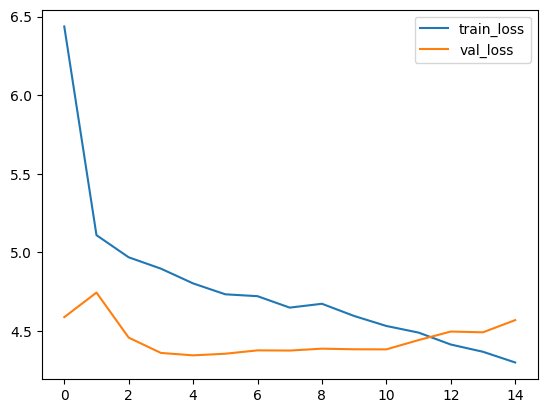

In [22]:
_ = log.plot()

In [23]:
class EvalSurv:

    def __init__(self, surv, durations, events, censor_surv=None, censor_durations=None, steps='post'):
        assert (type(durations) == type(events) == np.ndarray), 'Need `durations` and `events` to be arrays'
        self.surv = surv
        self.durations = durations
        self.events = events
        self.censor_surv = censor_surv
        self.censor_durations = censor_durations
        self.steps = steps
        assert pd.Series(self.index_surv).is_monotonic_increasing

    @property
    def censor_surv(self):
        """Estimated survival for censorings.
        Also an EvalSurv object.
        """
        return self._censor_surv

    @censor_surv.setter
    def censor_surv(self, censor_surv):
        if isinstance(censor_surv, EvalSurv):
            self._censor_surv = censor_surv
        elif type(censor_surv) is str:
            if censor_surv == 'km':
                self.add_km_censor()
            else:
                raise ValueError(f"censor_surv cannot be {censor_surv}. Use e.g. 'km'")
        elif censor_surv is not None:
            self.add_censor_est(censor_surv)
        else:
            self._censor_surv = None

    @property
    def index_surv(self):
        return self.surv.index.values

    @property
    def steps(self):

        return self._steps

    @steps.setter
    def steps(self, steps):
        vals = ['post', 'pre']
        if steps not in vals:
            raise ValueError(f"`steps` needs to be {vals}, got {steps}")
        self._steps = steps

    def add_censor_est(self, censor_surv, steps='post'):

        if not isinstance(censor_surv, EvalSurv):
            censor_surv = self._constructor(censor_surv, self.durations, 1-self.events, None,
                                            steps=steps)
        self.censor_surv = censor_surv
        return self

    def add_km_censor(self, steps='post'):

        km = utils.kaplan_meier(self.durations, 1-self.events)
        surv = pd.DataFrame(np.repeat(km.values.reshape(-1, 1), len(self.durations), axis=1),
                            index=km.index)
        return self.add_censor_est(surv, steps)

    @property
    def censor_durations(self):
        """Administrative censoring times."""
        return self._censor_durations

    @censor_durations.setter
    def censor_durations(self, val):
        if val is not None:
            assert (self.durations[self.events == 0] == val[self.events == 0]).all(),\
                'Censored observations need same `durations` and `censor_durations`'
            assert (self.durations[self.events == 1] <= val[self.events == 1]).all(),\
                '`durations` cannot be larger than `censor_durations`'
            if (self.durations == val).all():
                warnings.warn("`censor_durations` are equal to `durations`." +
                              " `censor_durations` are likely wrong!")
            self._censor_durations = val
        else:
            self._censor_durations = val

    @property
    def _constructor(self):
        return EvalSurv

    def __getitem__(self, index):
        if not (hasattr(index, '__iter__') or type(index) is slice) :
            index = [index]
        surv = self.surv.iloc[:, index]
        durations = self.durations[index]
        events = self.events[index]
        new = self._constructor(surv, durations, events, None, steps=self.steps)
        if self.censor_surv is not None:
            new.censor_surv = self.censor_surv[index]
        return new

    def plot_surv(self, **kwargs):

        if len(self.durations) > 50:
            raise RuntimeError("We don't allow to plot more than 50 lines. Use e.g. `ev[1:5].plot()`")
        if 'drawstyle' in kwargs:
            raise RuntimeError(f"`drawstyle` is set by `self.steps`. Remove from **kwargs")
        return self.surv.plot(drawstyle=f"steps-{self.steps}", **kwargs)

    def idx_at_times(self, times):

        return utils.idx_at_times(self.index_surv, times, self.steps)

    def _duration_idx(self):
        return self.idx_at_times(self.durations)

    def surv_at_times(self, times):
        idx = self.idx_at_times(times)
        return self.surv.iloc[idx]

    def concordance_td(self, method='adj_antolini'):

        return concordance_td(self.durations, self.events, self.surv.values,
                              self._duration_idx(), method)

    def brier_score(self, time_grid, max_weight=np.inf):

        if self.censor_surv is None:
            raise ValueError("""Need to add censor_surv to compute Brier score. Use 'add_censor_est'
            or 'add_km_censor' for Kaplan-Meier""")
        bs = ipcw.brier_score(time_grid, self.durations, self.events, self.surv.values,
                              self.censor_surv.surv.values, self.index_surv,
                              self.censor_surv.index_surv, max_weight, True, self.steps,
                              self.censor_surv.steps)
        return pd.Series(bs, index=time_grid).rename('brier_score')


    def integrated_brier_score(self, time_grid, max_weight=np.inf):

        if self.censor_surv is None:
            raise ValueError("Need to add censor_surv to compute briser score. Use 'add_censor_est'")
        return ipcw.integrated_brier_score(time_grid, self.durations, self.events, self.surv.values,
                                           self.censor_surv.surv.values, self.index_surv,
                                           self.censor_surv.index_surv, max_weight, self.steps,
                                           self.censor_surv.steps)


    def brier_score_admin(self, time_grid):

        if self.censor_durations is None:
            raise ValueError("Need to provide `censor_durations` (censoring durations) to use this method")
        bs = admin.brier_score(time_grid, self.durations, self.censor_durations, self.events,
                               self.surv.values, self.index_surv, True, self.steps)
        return pd.Series(bs, index=time_grid).rename('brier_score')

    def integrated_brier_score_admin(self, time_grid):

        if self.censor_durations is None:
            raise ValueError("Need to provide `censor_durations` (censoring durations) to use this method")
        ibs = admin.integrated_brier_score(time_grid, self.durations, self.censor_durations, self.events,
                                           self.surv.values, self.index_surv, self.steps)
        return ibs


In [24]:
_ = model.compute_baseline_hazards()

surv = model.predict_surv_df(x_test)
surv_train = model.predict_surv_df(x_train)

ev = EvalSurv(surv, durations_test, events_test, censor_surv='km')
ev_train = EvalSurv(surv_train , durations_train , events_train , censor_surv='km')

print(ev.concordance_td('antolini'))
print(ev_train.concordance_td('antolini'))

0.6500479786390755
0.7402433234594223


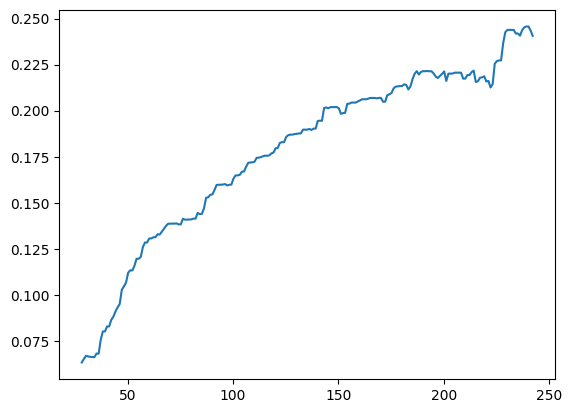

In [25]:
lower, upper = np.percentile(durations_test, [10, 90])
time_grid = np.arange(lower, upper + 1)

_ = ev.brier_score(time_grid).plot()

In [26]:
print(ev.integrated_brier_score(time_grid) )

0.17799956209415752


In [27]:
# heatmap

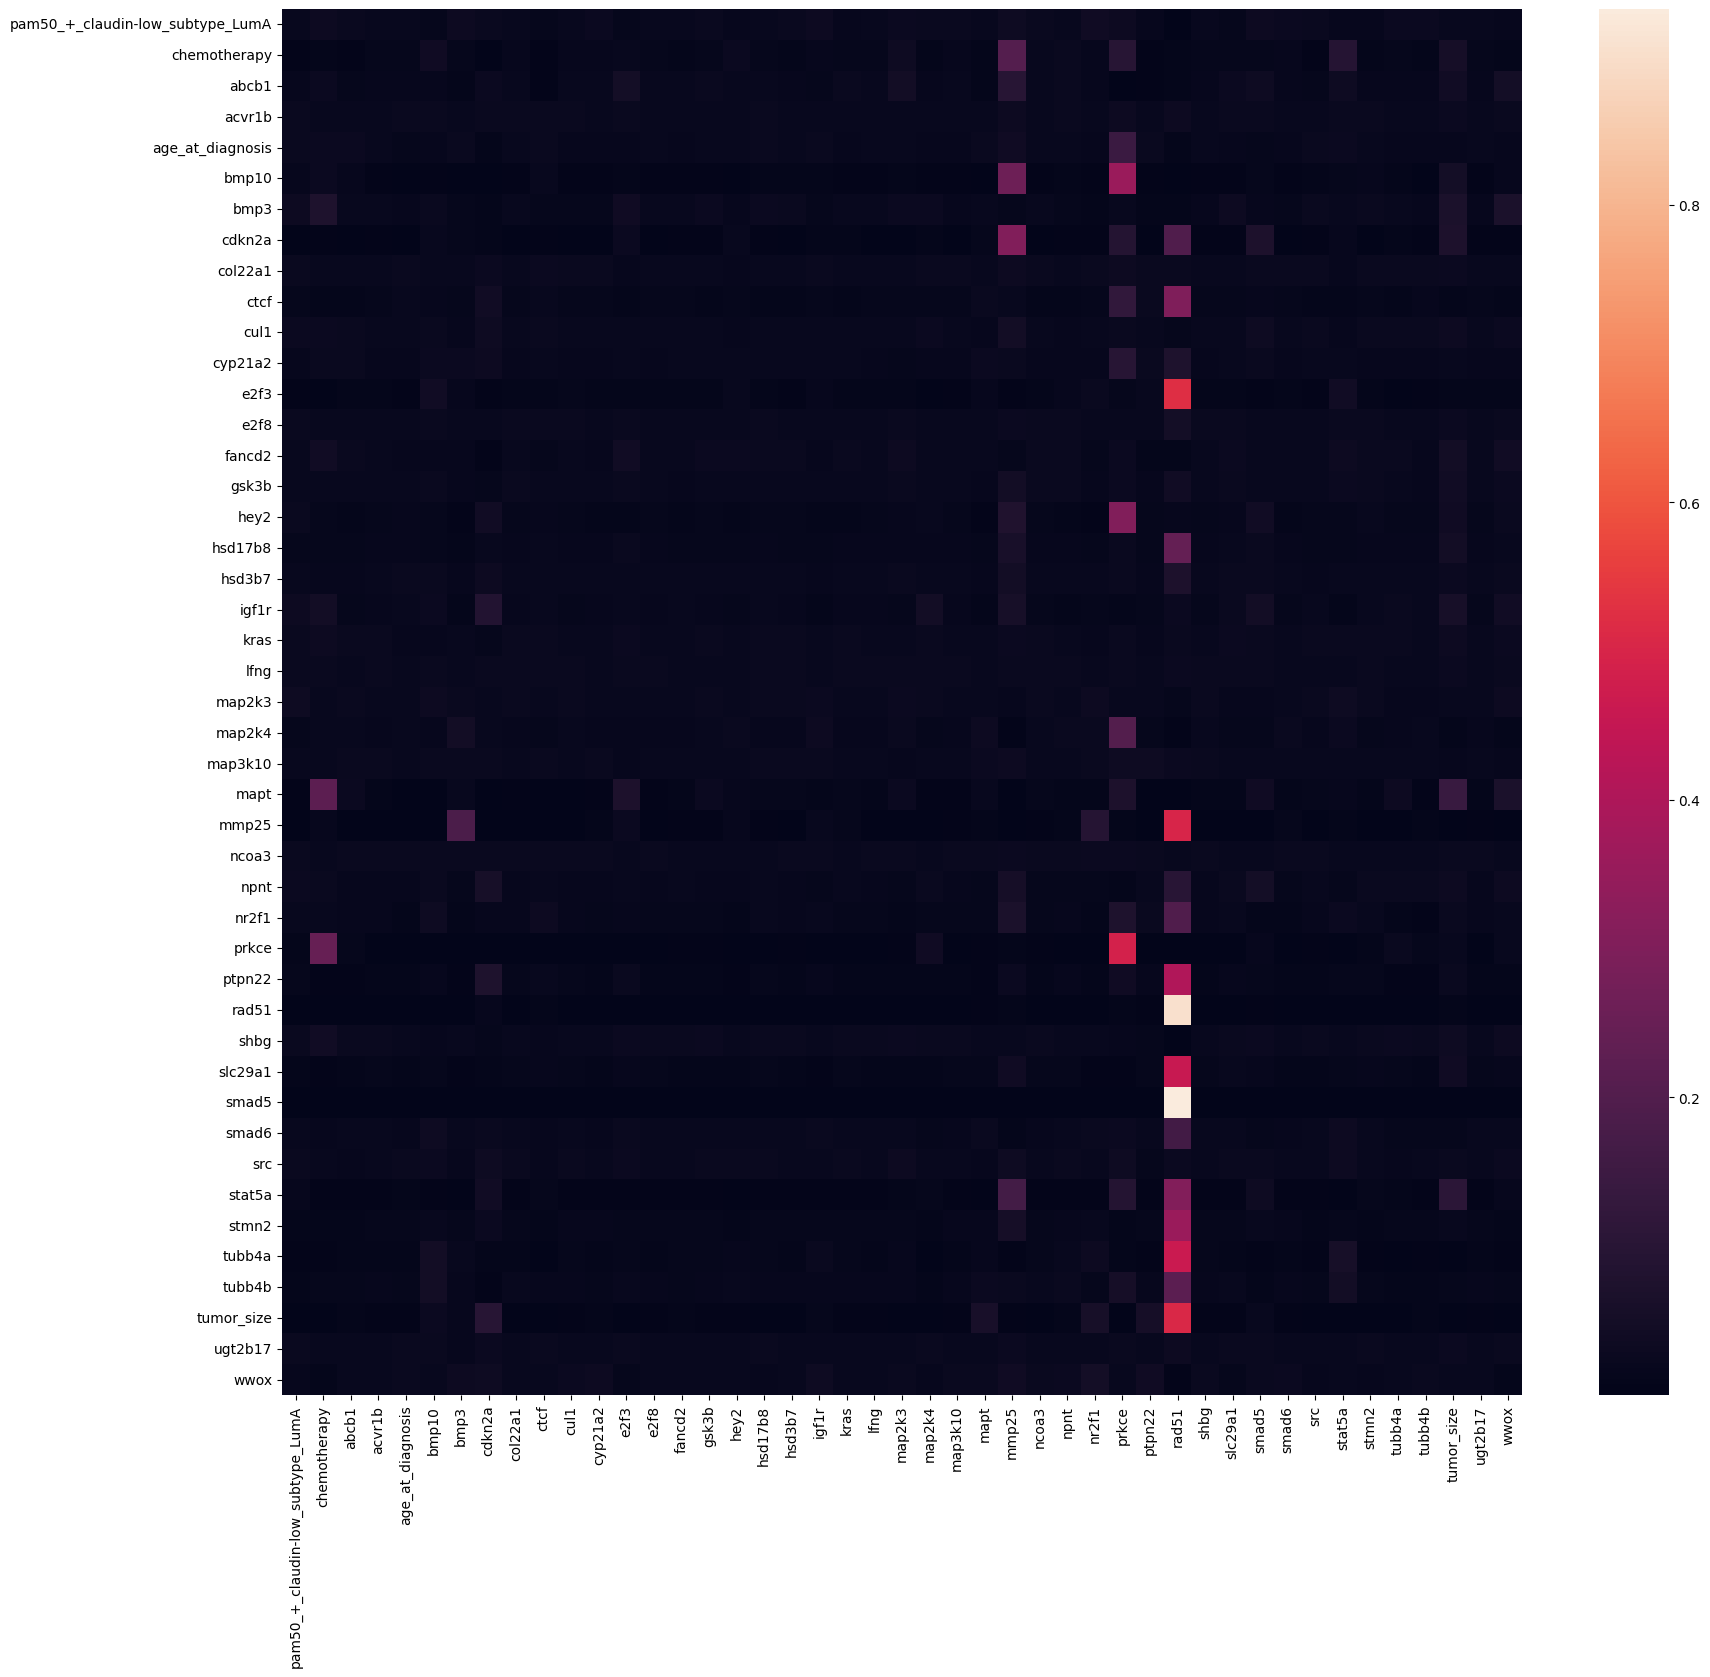

In [28]:
device = 'cuda'
patient_num = 1000
x = torch.tensor(x_train[patient_num][None,]).to(device)

# Get embeddings
embedding_layer = net.net[0]
attention_layer = net.net[1]

x = embedding_layer(x)
# Get attention heatmap
heatmap = attention_layer(x, extract_heatmap=True)

heatmaps = []

labels = df_train.columns.to_list()[:-2]
labels.remove(cat_cols[1])
labels.remove(cat_cols[0])
labels = cat_cols + labels
for i in range (heatmap.shape[1]):
    heatmaps.append(heatmap[0][i])
mean_heatmap  = np.mean(heatmaps, axis=0)
# print(mean_heatmap.shape)
plt.figure(figsize=(20, 18))
sns.heatmap(mean_heatmap, xticklabels=labels, yticklabels=labels)
plt.show()


In [29]:
list_layer  = [MLP__1_with_attention, MLP__2_with_attention, MLP__4_with_attention, MLP__6_with_attention, MLP__8_with_attention]

In [30]:

def errors_chheck (df_all,concordance_test, concordance_train, brier_test, num_et, categories, list_layer):

    all_concordance_test = []
    all_brier_test = []
    for name in list_layer:

        concordance_test = [] 
        concordance_train = [] 
        brier_test  = []

        for _ in (range(num_et)):

            df_train, df_temp = train_test_split(df_all, train_size=0.65, stratify =df_all['chemotherapy'])
            df_val, df_test = train_test_split(df_temp, test_size=0.5, stratify =df_temp['chemotherapy'])




            final_columns = df_train.columns.to_list()
            final_columns.remove('event')
            final_columns.remove('overall_survival_months')
            cat_cols = list(set(final_columns) & set(categories.to_list()))
            num_cols = list(set(final_columns) - set(cat_cols))


            x_train, vocab_size = preprocess_dataset(df_train, num_cols, cat_cols)
            x_val, _ = preprocess_dataset(df_val, num_cols, cat_cols)
            x_test, _ = preprocess_dataset(df_test, num_cols, cat_cols)


            EVENT_TIME =  "overall_survival_months"
            EVENT = "event"
            get_target = lambda df: (df[EVENT_TIME].values, df[EVENT].values)
            y_train = get_target(df_train)
            y_val = get_target(df_val)
            durations_test, events_test = get_target(df_test)
            val = x_val, y_val

            
            durations_train, events_train = get_target(df_train)


            in_features = len(final_columns)
            num_nodes = [50, 50]
            out_features = 1
            batch_norm = True
            dropout = 0.5
            output_bias = False
            num_numerical_feature = len(num_cols)
            vocab_size = int(vocab_size)

            num_features = x_train.shape[1]

            net = name(in_features, num_nodes, out_features, vocab_size, num_numerical_feature,num_features, batch_norm, dropout, output_bias=output_bias)


            optimizer = tt.optim.Adam(0.01)
            model = CoxPH(net, optimizer)

            model.optimizer.set_lr(0.005)
            epochs = 100
            batch_size=256
            callbacks = [tt.callbacks.EarlyStopping()]
            verbose = True

            log = model.fit(x_train, y_train, batch_size, epochs, callbacks, verbose,
                            val_data=val, val_batch_size=batch_size)
            

            _ = model.compute_baseline_hazards()

            surv = model.predict_surv_df(x_test)
            surv_train = model.predict_surv_df(x_train)

            ev = EvalSurv(surv, durations_test, events_test, censor_surv='km')
            ev_train = EvalSurv(surv_train , durations_train , events_train , censor_surv='km')
            lower, upper = np.percentile(durations_test, [10, 90])
            time_grid = np.arange(lower, upper + 1)
            concordance_test.append(ev.concordance_td('antolini'))
            concordance_train.append(ev_train.concordance_td('antolini'))
            brier_test.append(ev.integrated_brier_score(time_grid))

        all_concordance_test.append(np.array(concordance_test).mean())
        all_brier_test.append(np.array(brier_test).mean())

    return all_concordance_test, concordance_train, all_brier_test




In [31]:
num_et = 50
concordance_test = [] 
concordance_train = [] 
brier_test  = []
all_concordance_test, concordance_train, all_brier_test = errors_chheck(df_all,concordance_test, concordance_train, brier_test, num_et,categories, list_layer)


0:	[0s / 0s],		train_loss: 6.1065,	val_loss: 5.3951
1:	[0s / 0s],		train_loss: 5.4011,	val_loss: 4.6086
2:	[0s / 0s],		train_loss: 5.0178,	val_loss: 4.4411
3:	[0s / 0s],		train_loss: 4.9377,	val_loss: 4.3393
4:	[0s / 0s],		train_loss: 4.9156,	val_loss: 4.3309
5:	[0s / 0s],		train_loss: 4.8235,	val_loss: 4.3063
6:	[0s / 0s],		train_loss: 4.7353,	val_loss: 4.3039
7:	[0s / 0s],		train_loss: 4.7161,	val_loss: 4.3418
8:	[0s / 0s],		train_loss: 4.6736,	val_loss: 4.3221
9:	[0s / 0s],		train_loss: 4.6463,	val_loss: 4.2945
10:	[0s / 0s],		train_loss: 4.5883,	val_loss: 4.2688
11:	[0s / 0s],		train_loss: 4.5793,	val_loss: 4.2888
12:	[0s / 0s],		train_loss: 4.5113,	val_loss: 4.2674
13:	[0s / 1s],		train_loss: 4.4483,	val_loss: 4.3362
14:	[0s / 1s],		train_loss: 4.3947,	val_loss: 4.3389
15:	[0s / 1s],		train_loss: 4.3496,	val_loss: 4.3746
16:	[0s / 1s],		train_loss: 4.2769,	val_loss: 4.3447
17:	[0s / 2s],		train_loss: 4.2063,	val_loss: 4.4971
18:	[0s / 2s],		train_loss: 4.1282,	val_loss: 4.5740
19:

In [32]:
print(np.array(all_concordance_test).mean())
print(np.array(all_brier_test).mean())

0.6675033898413509
0.18398718018769808


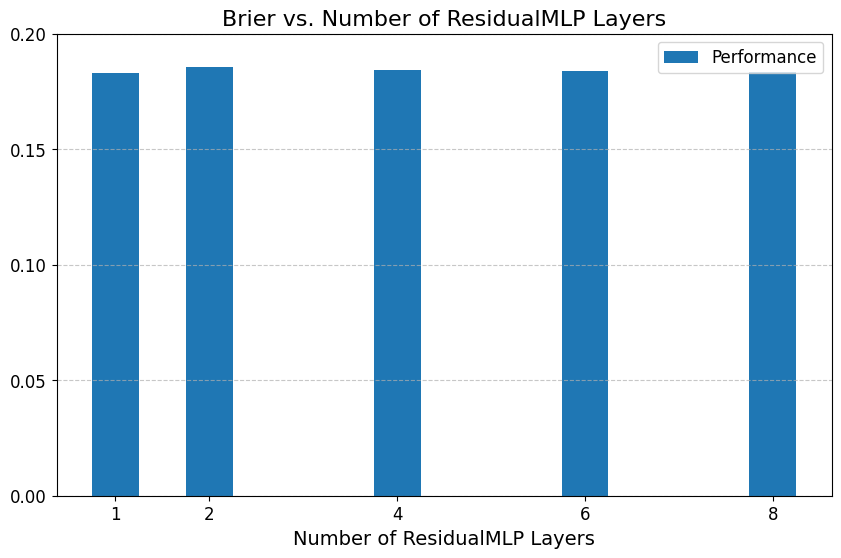

In [33]:
import matplotlib.pyplot as plt
import numpy as np
layers = [1, 2, 4, 6, 8]
values = all_brier_test

fig, ax = plt.subplots(figsize=(10, 6))

bar_width = 0.5
bars = ax.bar(layers, values, bar_width, label='Performance')


ax.set_xlabel('Number of ResidualMLP Layers', fontsize=14)

ax.set_title('Brier vs. Number of ResidualMLP Layers', fontsize=16)
ax.set_xticks(layers)
ax.set_yticks(np.arange(0, 0.71, 0.05))
ax.set_ylim(0, 0.2)
ax.tick_params(axis='both', which='major', labelsize=12)


ax.grid(True, axis='y', linestyle='--', alpha=0.7)


ax.legend(fontsize=12)

plt.show()


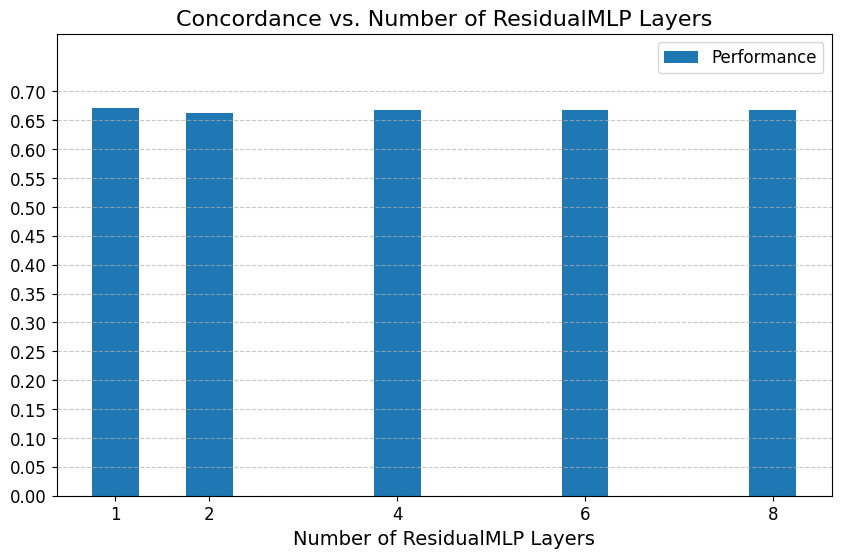

In [34]:
import matplotlib.pyplot as plt
import numpy as np

layers = [1, 2, 4, 6, 8]
values = all_concordance_test

fig, ax = plt.subplots(figsize=(10, 6))

bar_width = 0.5
bars = ax.bar(layers, values, bar_width, label='Performance')

ax.set_xlabel('Number of ResidualMLP Layers', fontsize=14)

ax.set_title('Concordance vs. Number of ResidualMLP Layers', fontsize=16)
ax.set_xticks(layers)
ax.set_yticks(np.arange(0, 0.71, 0.05))
ax.set_ylim(0, 0.8)
ax.tick_params(axis='both', which='major', labelsize=12)

ax.grid(True, axis='y', linestyle='--', alpha=0.7)


ax.legend(fontsize=12)

plt.show()


In [35]:

def errors_chheck_nodes (df_all,concordance_test, concordance_train, brier_test, num_et, categories, num_2_nodes):

    all_concordance_test = []
    all_brier_test = []
    for i in num_2_nodes:

        concordance_test = [] 
        concordance_train = [] 
        brier_test  = []

        for _ in (range(num_et)):

            df_train, df_temp = train_test_split(df_all, train_size=0.65, stratify =df_all['chemotherapy'])
            df_val, df_test = train_test_split(df_temp, test_size=0.5, stratify =df_temp['chemotherapy'])




            final_columns = df_train.columns.to_list()
            final_columns.remove('event')
            final_columns.remove('overall_survival_months')
            cat_cols = list(set(final_columns) & set(categories.to_list()))
            num_cols = list(set(final_columns) - set(cat_cols))


            x_train, vocab_size = preprocess_dataset(df_train, num_cols, cat_cols)
            x_val, _ = preprocess_dataset(df_val, num_cols, cat_cols)
            x_test, _ = preprocess_dataset(df_test, num_cols, cat_cols)


            EVENT_TIME =  "overall_survival_months"
            EVENT = "event"
            get_target = lambda df: (df[EVENT_TIME].values, df[EVENT].values)
            y_train = get_target(df_train)
            y_val = get_target(df_val)
            durations_test, events_test = get_target(df_test)
            val = x_val, y_val

            
            durations_train, events_train = get_target(df_train)


            in_features = len(final_columns)
            num_nodes = [50, i]
            out_features = 1
            batch_norm = True
            dropout = 0.5
            output_bias = False
            num_numerical_feature = len(num_cols)
            vocab_size = int(vocab_size)

            num_features = x_train.shape[1]

            net = MLP__2_with_attention(in_features, num_nodes, out_features, vocab_size, num_numerical_feature,num_features, batch_norm, dropout, output_bias=output_bias)


            optimizer = tt.optim.Adam(0.01)
            model = CoxPH(net, optimizer)

            model.optimizer.set_lr(0.005)
            epochs = 100
            batch_size=256
            callbacks = [tt.callbacks.EarlyStopping()]
            verbose = True

            log = model.fit(x_train, y_train, batch_size, epochs, callbacks, verbose,
                            val_data=val, val_batch_size=batch_size)
            

            _ = model.compute_baseline_hazards()

            surv = model.predict_surv_df(x_test)
            surv_train = model.predict_surv_df(x_train)

            ev = EvalSurv(surv, durations_test, events_test, censor_surv='km')
            ev_train = EvalSurv(surv_train , durations_train , events_train , censor_surv='km')
            lower, upper = np.percentile(durations_test, [10, 90])
            time_grid = np.arange(lower, upper + 1)
            concordance_test.append(ev.concordance_td('antolini'))
            concordance_train.append(ev_train.concordance_td('antolini'))
            brier_test.append(ev.integrated_brier_score(time_grid))

        all_concordance_test.append(np.array(concordance_test).mean())
        all_brier_test.append(np.array(brier_test).mean())

    return all_concordance_test, concordance_train, all_brier_test

In [36]:
num_2_nodes = [20,40,60,80]
num_et = 50
concordance_test = [] 
concordance_train = [] 
brier_test  = []
all_concordance_test_node, concordance_train, all_brier_test_node = errors_chheck_nodes(df_all,concordance_test, concordance_train, brier_test, num_et,categories, num_2_nodes)

0:	[0s / 0s],		train_loss: 6.9670,	val_loss: 5.0555
1:	[0s / 0s],		train_loss: 5.1762,	val_loss: 5.0238
2:	[0s / 0s],		train_loss: 5.1426,	val_loss: 4.6236
3:	[0s / 0s],		train_loss: 5.0274,	val_loss: 4.4499
4:	[0s / 0s],		train_loss: 4.9610,	val_loss: 4.4760
5:	[0s / 0s],		train_loss: 4.9381,	val_loss: 4.3628
6:	[0s / 0s],		train_loss: 4.9457,	val_loss: 4.3268
7:	[0s / 0s],		train_loss: 4.8596,	val_loss: 4.3017
8:	[0s / 0s],		train_loss: 4.8213,	val_loss: 4.3210
9:	[0s / 0s],		train_loss: 4.7872,	val_loss: 4.2897
10:	[0s / 0s],		train_loss: 4.7945,	val_loss: 4.2744
11:	[0s / 0s],		train_loss: 4.8032,	val_loss: 4.2637
12:	[0s / 0s],		train_loss: 4.7756,	val_loss: 4.2572
13:	[0s / 0s],		train_loss: 4.7341,	val_loss: 4.2488
14:	[0s / 0s],		train_loss: 4.7461,	val_loss: 4.2457
15:	[0s / 0s],		train_loss: 4.7155,	val_loss: 4.2542
16:	[0s / 1s],		train_loss: 4.6712,	val_loss: 4.2416
17:	[0s / 1s],		train_loss: 4.6292,	val_loss: 4.2383
18:	[0s / 1s],		train_loss: 4.6477,	val_loss: 4.2344
19:

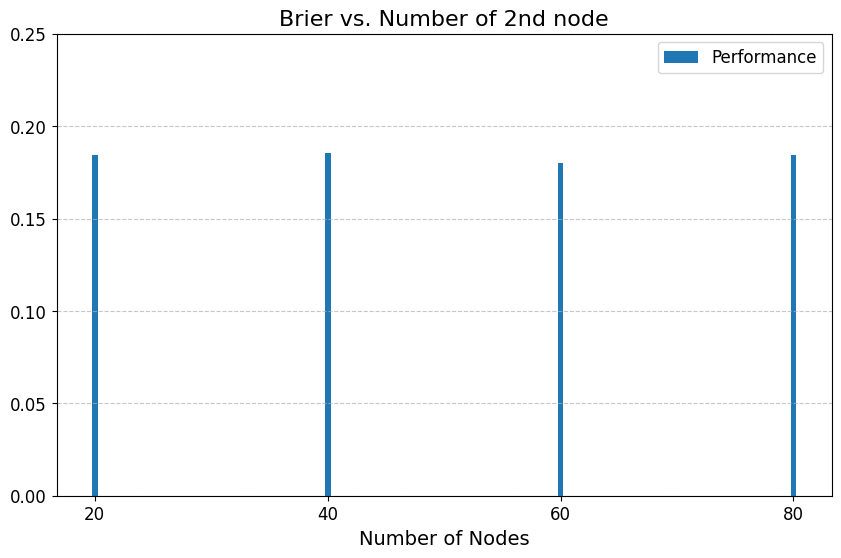

In [37]:
import matplotlib.pyplot as plt
import numpy as np

layers = [20,40,60,80]
values = all_brier_test_node

fig, ax = plt.subplots(figsize=(10, 6))

bar_width = 0.5
bars = ax.bar(layers, values, bar_width, label='Performance')

ax.set_xlabel('Number of Nodes', fontsize=14)

ax.set_title('Brier vs. Number of 2nd node', fontsize=16)
ax.set_xticks(layers)
ax.set_yticks(np.arange(0, 0.71, 0.05))
ax.set_ylim(0, 0.25)
ax.tick_params(axis='both', which='major', labelsize=12)

ax.grid(True, axis='y', linestyle='--', alpha=0.7)


ax.legend(fontsize=12)

plt.show()

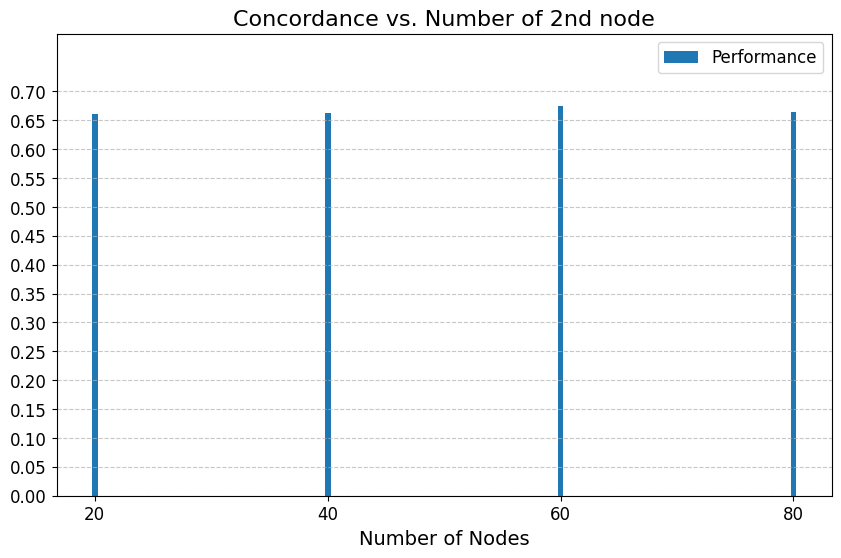

In [38]:
import matplotlib.pyplot as plt
import numpy as np

layers = [20,40,60,80]
values = all_concordance_test_node

fig, ax = plt.subplots(figsize=(10, 6))

bar_width = 0.5
bars = ax.bar(layers, values, bar_width, label='Performance')

ax.set_xlabel('Number of Nodes', fontsize=14)

ax.set_title('Concordance vs. Number of 2nd node', fontsize=16)
ax.set_xticks(layers)
ax.set_yticks(np.arange(0, 0.71, 0.05))
ax.set_ylim(0, 0.8)
ax.tick_params(axis='both', which='major', labelsize=12)

ax.grid(True, axis='y', linestyle='--', alpha=0.7)


ax.legend(fontsize=12)

plt.show()

In [47]:

def errors_chheck_justMLP (df_all,concordance_test, concordance_train, brier_test, num_et, categories):



    concordance_test = [] 
    concordance_train = [] 
    brier_test  = []

    for _ in (range(num_et)):

        df_train, df_temp = train_test_split(df_all, train_size=0.65, stratify =df_all['chemotherapy'])
        df_val, df_test = train_test_split(df_temp, test_size=0.5, stratify =df_temp['chemotherapy'])




        final_columns = df_train.columns.to_list()
        final_columns.remove('event')
        final_columns.remove('overall_survival_months')
        cat_cols = list(set(final_columns) & set(categories.to_list()))
        num_cols = list(set(final_columns) - set(cat_cols))


        x_train, vocab_size = preprocess_dataset(df_train, num_cols, cat_cols)
        x_val, _ = preprocess_dataset(df_val, num_cols, cat_cols)
        x_test, _ = preprocess_dataset(df_test, num_cols, cat_cols)


        EVENT_TIME =  "overall_survival_months"
        EVENT = "event"
        get_target = lambda df: (df[EVENT_TIME].values, df[EVENT].values)
        y_train = get_target(df_train)
        y_val = get_target(df_val)
        durations_test, events_test = get_target(df_test)
        val = x_val, y_val

        
        durations_train, events_train = get_target(df_train)


        in_features = len(final_columns)
        num_nodes = [50, 50]
        out_features = 1
        batch_norm = True
        dropout = 0.5
        output_bias = False
        num_numerical_feature = len(num_cols)
        vocab_size = int(vocab_size)

        num_features = x_train.shape[1]

        net = MLP_just_with_attention(in_features, num_nodes, out_features, vocab_size, num_numerical_feature,num_features, batch_norm, dropout, output_bias=output_bias)


        optimizer = tt.optim.Adam(0.01)
        model = CoxPH(net, optimizer)

        model.optimizer.set_lr(0.005)
        epochs = 100
        batch_size=256
        callbacks = [tt.callbacks.EarlyStopping()]
        verbose = True

        log = model.fit(x_train, y_train, batch_size, epochs, callbacks, verbose,
                        val_data=val, val_batch_size=batch_size)
        

        _ = model.compute_baseline_hazards()

        surv = model.predict_surv_df(x_test)
        surv_train = model.predict_surv_df(x_train)

        ev = EvalSurv(surv, durations_test, events_test, censor_surv='km')
        ev_train = EvalSurv(surv_train , durations_train , events_train , censor_surv='km')
        lower, upper = np.percentile(durations_test, [10, 90])
        time_grid = np.arange(lower, upper + 1)
        concordance_test.append(ev.concordance_td('antolini'))
        concordance_train.append(ev_train.concordance_td('antolini'))
        brier_test.append(ev.integrated_brier_score(time_grid))
        


    return concordance_test, concordance_train, brier_test

In [48]:
num_et = 50
concordance_test = [] 
concordance_train = [] 
brier_test  = []
concordance_test_just_MLP, concordance_train, brier_test_just_MLP = errors_chheck_justMLP(df_all,concordance_test, concordance_train, brier_test, num_et,categories)
print(np.array(concordance_test_just_MLP).mean())
print(np.array(brier_test_just_MLP).mean())

0:	[0s / 0s],		train_loss: 7.2337,	val_loss: 5.2305
1:	[0s / 0s],		train_loss: 5.8681,	val_loss: 5.0113
2:	[0s / 0s],		train_loss: 5.2756,	val_loss: 4.6350
3:	[0s / 0s],		train_loss: 5.0599,	val_loss: 4.2770
4:	[0s / 0s],		train_loss: 4.9809,	val_loss: 4.2328
5:	[0s / 0s],		train_loss: 4.9416,	val_loss: 4.2253
6:	[0s / 0s],		train_loss: 4.8637,	val_loss: 4.2616
7:	[0s / 0s],		train_loss: 4.8264,	val_loss: 4.2762
8:	[0s / 0s],		train_loss: 4.8033,	val_loss: 4.3027
9:	[0s / 0s],		train_loss: 4.7483,	val_loss: 4.3034
10:	[0s / 0s],		train_loss: 4.7129,	val_loss: 4.3333
11:	[0s / 0s],		train_loss: 4.6920,	val_loss: 4.3906
12:	[0s / 0s],		train_loss: 4.6558,	val_loss: 4.3334
13:	[0s / 0s],		train_loss: 4.6513,	val_loss: 4.3463
14:	[0s / 0s],		train_loss: 4.4994,	val_loss: 4.4506
15:	[0s / 0s],		train_loss: 4.5370,	val_loss: 4.4421
0:	[0s / 0s],		train_loss: 6.4292,	val_loss: 4.5488
1:	[0s / 0s],		train_loss: 5.1431,	val_loss: 4.6237
2:	[0s / 0s],		train_loss: 5.0756,	val_loss: 4.4881
3:	[0s

In [49]:
print(np.array(concordance_test_just_MLP).mean())
print(np.array(brier_test_just_MLP).mean())

0.6634079275903574
0.18331777581738767


In [90]:
import numpy as np
import torch
import torchtuples as tt
import seaborn as sns
import pandas as pd
import math, copy
import torch.nn as nn
import torch.nn.functional as F
from torchtuples.tupletree import tuplefy
from torch.autograd import Variable
from torch.utils.data import Dataset, DataLoader

#import eli5
# from eli5.sklearn import PermutationImportance
# from eli5.permutation_importance import get_score_importances
# For preprocessing

from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn_pandas import DataFrameMapper
from sklearn.model_selection import train_test_split

from pycox.models import CoxPH
from pycox.models import LogisticHazard
from pycox.evaluation import EvalSurv
from pycox.evaluation.concordance import concordance_td
from pycox.evaluation import ipcw, admin
from pycox import utils

from statsmodels.stats.outliers_influence import variance_inflation_factor
from statsmodels.tools.tools import add_constant

import matplotlib.pyplot as plt
import matplotlib
from lifelines import *
from lifelines.utils import concordance_index   #from concordance import concordance_index
from operator import itemgetter

import warnings
warnings.filterwarnings('ignore')

In [91]:
df_all = pd.read_csv('Metabric_selected.csv')
df_all.drop('Unnamed: 0', inplace=True, axis=1)

In [92]:
categories = pd.Index(['cellularity',
 'neoplasm_histologic_grade'])

In [93]:
def preprocess_dataset(data, data_train, num_cols, cat_cols):
    scaler = StandardScaler()
    scaler.fit(data_train[num_cols])
    standardize = [([col], scaler) for col in num_cols]
    x_mapper = DataFrameMapper(standardize)
    input_x_num = x_mapper.fit_transform(data).astype('float32')
    input_ids = np.zeros([input_x_num.shape[0], len(cat_cols)])
    vocab_size = 0
    for i,feat in enumerate(cat_cols):
        input_ids[:,i] = LabelEncoder().fit_transform(data[feat]).astype('float32') + vocab_size
        vocab_size += data[feat].max() + 1
    return np.concatenate((input_ids, input_x_num), axis=1), vocab_size

In [94]:
class EvalSurv:

    def __init__(self, surv, durations, events, censor_surv=None, censor_durations=None, steps='post'):
        assert (type(durations) == type(events) == np.ndarray), 'Need `durations` and `events` to be arrays'
        self.surv = surv
        self.durations = durations
        self.events = events
        self.censor_surv = censor_surv
        self.censor_durations = censor_durations
        self.steps = steps
        assert pd.Series(self.index_surv).is_monotonic_increasing

    @property
    def censor_surv(self):
        """Estimated survival for censorings.
        Also an EvalSurv object.
        """
        return self._censor_surv

    @censor_surv.setter
    def censor_surv(self, censor_surv):
        if isinstance(censor_surv, EvalSurv):
            self._censor_surv = censor_surv
        elif type(censor_surv) is str:
            if censor_surv == 'km':
                self.add_km_censor()
            else:
                raise ValueError(f"censor_surv cannot be {censor_surv}. Use e.g. 'km'")
        elif censor_surv is not None:
            self.add_censor_est(censor_surv)
        else:
            self._censor_surv = None

    @property
    def index_surv(self):
        return self.surv.index.values

    @property
    def steps(self):

        return self._steps

    @steps.setter
    def steps(self, steps):
        vals = ['post', 'pre']
        if steps not in vals:
            raise ValueError(f"`steps` needs to be {vals}, got {steps}")
        self._steps = steps

    def add_censor_est(self, censor_surv, steps='post'):

        if not isinstance(censor_surv, EvalSurv):
            censor_surv = self._constructor(censor_surv, self.durations, 1-self.events, None,
                                            steps=steps)
        self.censor_surv = censor_surv
        return self

    def add_km_censor(self, steps='post'):

        km = utils.kaplan_meier(self.durations, 1-self.events)
        surv = pd.DataFrame(np.repeat(km.values.reshape(-1, 1), len(self.durations), axis=1),
                            index=km.index)
        return self.add_censor_est(surv, steps)

    @property
    def censor_durations(self):
        """Administrative censoring times."""
        return self._censor_durations

    @censor_durations.setter
    def censor_durations(self, val):
        if val is not None:
            assert (self.durations[self.events == 0] == val[self.events == 0]).all(),\
                'Censored observations need same `durations` and `censor_durations`'
            assert (self.durations[self.events == 1] <= val[self.events == 1]).all(),\
                '`durations` cannot be larger than `censor_durations`'
            if (self.durations == val).all():
                warnings.warn("`censor_durations` are equal to `durations`." +
                              " `censor_durations` are likely wrong!")
            self._censor_durations = val
        else:
            self._censor_durations = val

    @property
    def _constructor(self):
        return EvalSurv

    def __getitem__(self, index):
        if not (hasattr(index, '__iter__') or type(index) is slice) :
            index = [index]
        surv = self.surv.iloc[:, index]
        durations = self.durations[index]
        events = self.events[index]
        new = self._constructor(surv, durations, events, None, steps=self.steps)
        if self.censor_surv is not None:
            new.censor_surv = self.censor_surv[index]
        return new

    def plot_surv(self, **kwargs):

        if len(self.durations) > 50:
            raise RuntimeError("We don't allow to plot more than 50 lines. Use e.g. `ev[1:5].plot()`")
        if 'drawstyle' in kwargs:
            raise RuntimeError(f"`drawstyle` is set by `self.steps`. Remove from **kwargs")
        return self.surv.plot(drawstyle=f"steps-{self.steps}", **kwargs)

    def idx_at_times(self, times):

        return utils.idx_at_times(self.index_surv, times, self.steps)

    def _duration_idx(self):
        return self.idx_at_times(self.durations)

    def surv_at_times(self, times):
        idx = self.idx_at_times(times)
        return self.surv.iloc[idx]

    def concordance_td(self, method='adj_antolini'):

        return concordance_td(self.durations, self.events, self.surv.values,
                              self._duration_idx(), method)

    def brier_score(self, time_grid, max_weight=np.inf):

        if self.censor_surv is None:
            raise ValueError("""Need to add censor_surv to compute Brier score. Use 'add_censor_est'
            or 'add_km_censor' for Kaplan-Meier""")
        bs = ipcw.brier_score(time_grid, self.durations, self.events, self.surv.values,
                              self.censor_surv.surv.values, self.index_surv,
                              self.censor_surv.index_surv, max_weight, True, self.steps,
                              self.censor_surv.steps)
        return pd.Series(bs, index=time_grid).rename('brier_score')


    def integrated_brier_score(self, time_grid, max_weight=np.inf):

        if self.censor_surv is None:
            raise ValueError("Need to add censor_surv to compute briser score. Use 'add_censor_est'")
        return ipcw.integrated_brier_score(time_grid, self.durations, self.events, self.surv.values,
                                           self.censor_surv.surv.values, self.index_surv,
                                           self.censor_surv.index_surv, max_weight, self.steps,
                                           self.censor_surv.steps)


    def brier_score_admin(self, time_grid):

        if self.censor_durations is None:
            raise ValueError("Need to provide `censor_durations` (censoring durations) to use this method")
        bs = admin.brier_score(time_grid, self.durations, self.censor_durations, self.events,
                               self.surv.values, self.index_surv, True, self.steps)
        return pd.Series(bs, index=time_grid).rename('brier_score')

    def integrated_brier_score_admin(self, time_grid):

        if self.censor_durations is None:
            raise ValueError("Need to provide `censor_durations` (censoring durations) to use this method")
        ibs = admin.integrated_brier_score(time_grid, self.durations, self.censor_durations, self.events,
                                           self.surv.values, self.index_surv, self.steps)
        return ibs

In [95]:
import torch
import torch.nn as nn
import torch.nn.functional as F

# Function to ensure all inputs are tuples
def tuplefy(*args):
    return tuple([arg if isinstance(arg, (tuple, list)) else (arg,) for arg in args])

class BertEmbeddings(nn.Module):
    def __init__(self, vocab_size, hidden_size, num_numerical_feature, max_position_embeddings):
        super().__init__()
        self.word_embeddings = nn.Embedding(vocab_size, hidden_size)
        self.position_embeddings = nn.Embedding(max_position_embeddings, hidden_size)
        self.num_embeddings = nn.Parameter(torch.randn(1, num_numerical_feature, hidden_size), requires_grad=True)
        self.num_numerical_feature = num_numerical_feature

    def forward(self, input):
        input_ids = input[:, :-self.num_numerical_feature].to(torch.int)
        inputs_embeds = self.word_embeddings(input_ids)

        position_ids = torch.arange(inputs_embeds.size(1), dtype=torch.long, device=input.device)
        position_ids = position_ids.unsqueeze(0).expand_as(input_ids)
        position_embeds = self.position_embeddings(position_ids)

        input_x_num = input[:, -self.num_numerical_feature:]
        num_embeddings = torch.unsqueeze(input_x_num, 2) * self.num_embeddings

        embeddings = torch.cat([inputs_embeds, num_embeddings], axis=1)
        embeddings = embeddings.to(torch.float)
        return embeddings


class MultiHeadSelfAttentionLayer(nn.Module):
    def __init__(self, hidden_size, num_heads):
        super(MultiHeadSelfAttentionLayer, self).__init__()
        self.num_heads = num_heads
        self.hidden_size = hidden_size
        self.head_dim = hidden_size // num_heads

        assert self.head_dim * num_heads == hidden_size, "hidden_size must be divisible by num_heads"

        self.key = nn.Linear(hidden_size, hidden_size)
        self.query = nn.Linear(hidden_size, hidden_size)
        self.value = nn.Linear(hidden_size, hidden_size)
        self.out = nn.Linear(hidden_size, hidden_size)

    def forward(self, x, mask=None, extract_heatmap=False):
        batch_size = x.size(0)
        seq_length = x.size(1)

        keys = self.key(x).view(batch_size, seq_length, self.num_heads, self.head_dim).transpose(1, 2)
        queries = self.query(x).view(batch_size, seq_length, self.num_heads, self.head_dim).transpose(1, 2)
        values = self.value(x).view(batch_size, seq_length, self.num_heads, self.head_dim).transpose(1, 2)

        scores = torch.matmul(queries, keys.transpose(-2, -1)) / torch.sqrt(torch.tensor(self.head_dim, dtype=torch.float32))

        if mask is not None:
            scores = scores.masked_fill(mask == 0, -1e9)

        attention_weights = F.softmax(scores, dim=-1)

        if extract_heatmap:
            return attention_weights.detach().cpu().numpy()  # Extract attention weights for all examples in batch

        output = torch.matmul(attention_weights, values)
        output = output.transpose(1, 2).contiguous().view(batch_size, seq_length, self.hidden_size)

        output = self.out(output)
        return output, attention_weights


class ResidualMLPBlock(nn.Module):
    def __init__(self, in_features, out_features, bias=True, batch_norm=False, dropout=0., activation=nn.ReLU,
                 w_init_=lambda w: nn.init.kaiming_normal_(w, nonlinearity='relu'), batch_features=0):
        super().__init__()
        self.linear = nn.Linear(in_features, out_features, bias)
        if w_init_:
            w_init_(self.linear.weight.data)
        self.activation = activation()
        self.batch_norm = nn.BatchNorm1d(batch_features) if batch_norm else None
        self.dropout = nn.Dropout(dropout) if dropout else None
        self.residual = nn.Linear(in_features, out_features) if in_features != out_features else nn.Identity()

    def forward(self, input):
        residual = self.residual(input)
        input = self.activation(self.linear(input))
        if self.batch_norm:
            input = self.batch_norm(input)
        if self.dropout:
            input = self.dropout(input)
        return input + residual

class MLPBlock2(nn.Module):
    def __init__(self, in_features, out_features, bias=True, batch_norm=False, dropout=0., activation=nn.ReLU,
                 w_init_=lambda w: nn.init.kaiming_normal_(w, nonlinearity='relu'), batch_features=0):
        super().__init__()
        self.linear = nn.Linear(in_features, out_features, bias)
        if w_init_:
            w_init_(self.linear.weight.data)
        self.activation = activation()
        self.batch_norm = nn.BatchNorm1d(batch_features) if batch_norm else None
        self.dropout = nn.Dropout(dropout) if dropout else None

    def forward(self, input):
        input = self.activation(self.linear(input))
        if self.batch_norm:
            input = self.batch_norm(input)
        if self.dropout:
            input = self.dropout(input)
        return input

class CLF(nn.Module):
    def __init__(self, in_features, out_features, num_features, bias=True, dropout = 0, activation=nn.ReLU,
                 w_init_=lambda w: nn.init.kaiming_normal_(w, nonlinearity='relu')):
        super().__init__()
        self.mlp = MLPBlock2(in_features * num_features, in_features, True, True, 0.2, activation, w_init_, in_features)
        self.linear = nn.Linear(in_features, out_features, bias)
        if w_init_:
            w_init_(self.linear.weight.data)

    def forward(self, input):
        input = input.flatten(1)
        input = self.mlp(input)
        input = self.linear(input)
        return input

class MLP_with_attention(nn.Module):
    def __init__(self, num_heads, in_features, num_nodes, out_features, vocab_size, num_numerical_feature,num_features, batch_norm=False, dropout=None, activation=nn.ReLU,
                 output_activation=None, output_bias=True,
                 w_init_=lambda w: nn.init.kaiming_normal_(w, nonlinearity='relu'), embed_dim=16, max_position_embeddings=512):
        super().__init__()
        num_nodes_len = tuplefy(num_nodes)  # Correctly tuplefy `num_nodes`
        dropout = [dropout for _ in range(len(num_nodes_len)-1)]
        net = []
        net.append(BertEmbeddings(vocab_size, embed_dim, num_numerical_feature, max_position_embeddings))
        net.append(MultiHeadSelfAttentionLayer(embed_dim, num_heads))
        net.append(nn.LayerNorm(embed_dim))
        # for i in range(len(num_nodes) - 1):
        net.append(ResidualMLPBlock(embed_dim, num_nodes[0], True, batch_norm, dropout, activation, w_init_, num_features))
        net.append(ResidualMLPBlock(num_nodes[0], num_nodes[1], True, batch_norm, dropout, activation, w_init_ , num_features))

        net.append(CLF(num_nodes[-1], out_features, num_features, output_bias, dropout))  # Last layer uses the last num_node value
        if output_activation:
            net.append(output_activation)
        self.net = nn.Sequential(*net)

    def forward(self, input):
        embeddings = self.net[0](input)
        attention_output, _ = self.net[1](embeddings)
        attention_output = self.net[2](attention_output)
        output = self.net[3:](attention_output)
        return output



In [96]:
def AttentionDeepCox(df_all, num_et, num_heads, categories, return_map=False, patients_list=None):

    concordance_test = []
    concordance_train = []
    brier_test  = []
    mean_heatmap = []

    for rs in (range(num_et)):


        df_train, df_temp = train_test_split(df_all, train_size=0.65, stratify =df_all['chemotherapy'], random_state=rs)
        df_val, df_test = train_test_split(df_temp, test_size=0.5, stratify =df_temp['chemotherapy'], random_state=rs)


        final_columns = df_train.columns.to_list()
        final_columns.remove('event')
        final_columns.remove('overall_survival_months')
        cat_cols = list(set(final_columns) & set(categories.to_list()))
        num_cols = list(set(final_columns) - set(cat_cols))


        x_train, vocab_size = preprocess_dataset(df_train, df_train, num_cols, cat_cols)
        x_val, _ = preprocess_dataset(df_val, df_train, num_cols, cat_cols)
        x_test, _ = preprocess_dataset(df_test, df_train, num_cols, cat_cols)


        EVENT_TIME =  "overall_survival_months"
        EVENT = "event"
        get_target = lambda df: (df[EVENT_TIME].values, df[EVENT].values)
        y_train = get_target(df_train)
        y_val = get_target(df_val)
        durations_test, events_test = get_target(df_test)
        val = x_val, y_val

        #
        durations_train, events_train = get_target(df_train)


        in_features = len(final_columns)
        num_nodes = [50, 50]
        out_features = 1
        batch_norm = True
        dropout = 0.5
        output_bias = False
        num_numerical_feature = len(num_cols)
        vocab_size = int(vocab_size)

        num_features = x_train.shape[1]

        net = MLP_with_attention(num_heads, in_features, num_nodes, out_features, vocab_size, num_numerical_feature,num_features, batch_norm, dropout, output_bias=output_bias)


        optimizer = tt.optim.Adam(0.01)
        model = CoxPH(net, optimizer)

        model.optimizer.set_lr(0.005)
        epochs = 100
        batch_size=256
        callbacks = [tt.callbacks.EarlyStopping()]
        verbose = True

        log = model.fit(x_train, y_train, batch_size, epochs, callbacks, verbose,
                        val_data=val, val_batch_size=batch_size)


        _ = model.compute_baseline_hazards()

        surv = model.predict_surv_df(x_test)
        surv_train = model.predict_surv_df(x_train)

        ev = EvalSurv(surv, durations_test, events_test, censor_surv='km')
        ev_train = EvalSurv(surv_train , durations_train , events_train , censor_surv='km')
        lower, upper = np.percentile(durations_test, [10, 90])
        time_grid = np.arange(lower, upper + 1)
        concordance_test.append(ev.concordance_td('antolini'))
        concordance_train.append(ev_train.concordance_td('antolini'))
        brier_test.append(ev.integrated_brier_score(time_grid))


        if return_map == True:
          device = 'cuda'
          patients_heatmap = []
          for patient_num in patients_list:
            x = torch.tensor(x_train[patient_num][None,]).to(device)

            # Get embeddings
            embedding_layer = net.net[0]
            attention_layer = net.net[1]

            x = embedding_layer(x)
            # Get attention heatmap
            heatmap = attention_layer(x, extract_heatmap=True)

            heatmaps = []

            labels = df_train.columns.to_list()[:-2]
            #labels.remove(cat_cols[1])
            #labels.remove(cat_cols[0])
            #labels = cat_cols + labels
            for i in range (heatmap.shape[1]):
                heatmaps.append(heatmap[0][i])
            mean_heatmap  = np.mean(heatmaps, axis=0)

            patients_heatmap.append(mean_heatmap)

          map = np.mean(patients_heatmap, axis=0)
        else:
          map = 0


    return concordance_test, concordance_train, brier_test, map





In [97]:
import seaborn as sns

In [98]:
C_test_heads = {}
B_test_heads = {}
for num_heads in [1,2,4,8,16]:
    num_et = 50
    concordance_test, concordance_train, brier_test, _ = AttentionDeepCox(df_all, num_et, num_heads, categories)
    C_test_heads[num_heads]= np.array(concordance_test)
    B_test_heads[num_heads]= np.array(brier_test)

0:	[0s / 0s],		train_loss: 6.5717,	val_loss: 5.3768
1:	[0s / 0s],		train_loss: 5.1899,	val_loss: 4.6561
2:	[0s / 0s],		train_loss: 5.0889,	val_loss: 4.3644
3:	[0s / 0s],		train_loss: 4.9828,	val_loss: 4.4051
4:	[0s / 0s],		train_loss: 4.9476,	val_loss: 4.3719
5:	[0s / 0s],		train_loss: 4.9079,	val_loss: 4.3416
6:	[0s / 0s],		train_loss: 4.8798,	val_loss: 4.3490
7:	[0s / 0s],		train_loss: 4.7930,	val_loss: 4.3609
8:	[0s / 0s],		train_loss: 4.8584,	val_loss: 4.3245
9:	[0s / 0s],		train_loss: 4.8039,	val_loss: 4.3082
10:	[0s / 0s],		train_loss: 4.7646,	val_loss: 4.3361
11:	[0s / 0s],		train_loss: 4.7399,	val_loss: 4.3949
12:	[0s / 0s],		train_loss: 4.7095,	val_loss: 4.3929
13:	[0s / 0s],		train_loss: 4.7604,	val_loss: 4.3817
14:	[0s / 0s],		train_loss: 4.6475,	val_loss: 4.3793
15:	[0s / 0s],		train_loss: 4.6333,	val_loss: 4.3962
16:	[0s / 0s],		train_loss: 4.6094,	val_loss: 4.4176
17:	[0s / 0s],		train_loss: 4.6403,	val_loss: 4.6858
18:	[0s / 1s],		train_loss: 4.8221,	val_loss: 4.6204
19:

{1: 0.6806059705198143, 2: 0.6753494062491118, 4: 0.6710427781218506, 8: 0.6708271128711243, 16: 0.6798974841125848}


<Axes: >

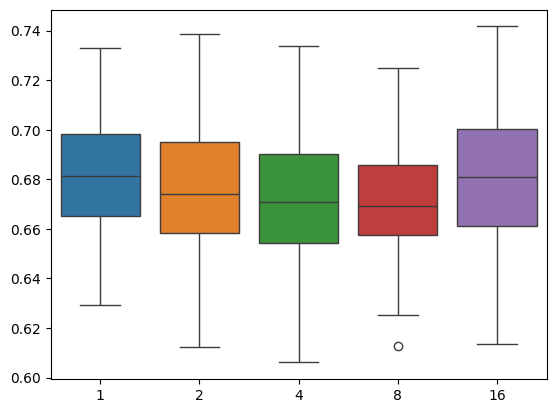

In [99]:
mean = {}
for key, value in C_test_heads.items():
    mean[key] = np.mean(value)
print(mean)
sns.boxplot(C_test_heads)

{1: 0.18135827349832603, 2: 0.1810129626598185, 4: 0.18321768708141367, 8: 0.18285713526971498, 16: 0.1798952659852911}


<Axes: >

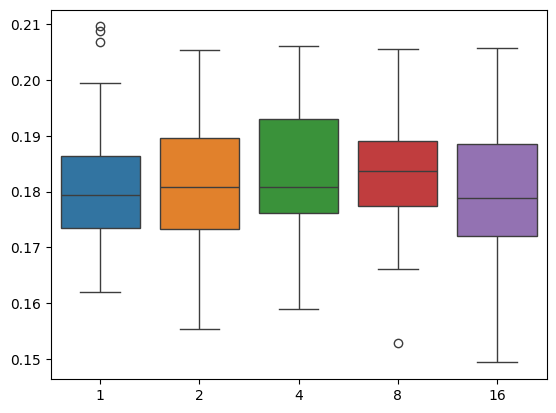

In [100]:
mean = {}
for key, value in B_test_heads.items():
    mean[key] = np.mean(value)
print(mean)
sns.boxplot(B_test_heads)